In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import hhRNA1, hhATAC1, shareseq

from utils import *
from model.loss import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
shareseq_dataset = shareseq(standardize=False, atac_seq_file = "./data/SHARE-seq/scATAC_lsi.csv", 
    rna_seq_file = "./data/SHARE-seq/scRNA.csv", celltype_file = "./data/SHARE-seq/celltypes.txt")

shareseq_rna_CONFIG = { 
    'in_features': 1000,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 32,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

shareseq_atac_CONFIG = { 
    'in_features': 99,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 32,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}


train_shareseq_loader = DataLoader(shareseq_dataset, batch_size = 32, shuffle = True)
test_shareseq_loader = DataLoader(shareseq_dataset, batch_size = len(shareseq_dataset), shuffle = False)

for data in test_shareseq_loader:
    Diff1 = diff.phate_similarity(data["raw_rna"], 
                                  n_neigh = 30, 
                                  t = 10, 
                                  use_potential = True)

    Diff2 = diff.phate_similarity(data["raw_atac"], 
                                  n_neigh = 30, 
                                  t = 10, 
                                  use_potential = True)
    
    DPT1 = diff.DPT_similarity(data["raw_rna"], 
                               n_neigh = 30, 
                               use_potential = True)

    DPT2 = diff.DPT_similarity(data["raw_atac"], 
                               n_neigh = 30, 
                               use_potential = True)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)

    Diff2 = torch.FloatTensor(Diff2).to(device)
    
    DPT1 = torch.FloatTensor(DPT1).to(device)

    DPT2 = torch.FloatTensor(DPT2).to(device)    


In [3]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(shareseq_rna_CONFIG)), 
        ("decoder", ae.Decoder(shareseq_rna_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(shareseq_atac_CONFIG)), 
        ("decoder", ae.Decoder(shareseq_atac_CONFIG))
      ])).to(device)


optimizer_rna = torch.optim.Adam(ae1.parameters(), lr = 5e-4)
optimizer_atac = torch.optim.Adam(ae2.parameters(), lr = 5e-4)

In [4]:
train_paired(model_rna = ae1, model_atac = ae2, data_loader = train_shareseq_loader, diff_sim_rna = Diff1, 
             diff_sim_atac = Diff2, optimizer_rna = optimizer_rna, optimizer_atac = optimizer_atac, n_epochs = 50, 
             lamb_r_rna = 0, lamb_r_atac = 0, lambda_pair = 0.0)

epoch:  0 RNA loss: -0.99189, RNA recon loss: 0.00000, RNA dist loss: -0.99189 ATAC loss: -0.98367, ATAC recon loss: 0.00000, ATAC dist loss: -0.98367 Diff loss: 0.00000
epoch:  10 RNA loss: -0.99350, RNA recon loss: 0.00000, RNA dist loss: -0.99350 ATAC loss: -0.99192, ATAC recon loss: 0.00000, ATAC dist loss: -0.99192 Diff loss: 0.00000
epoch:  20 RNA loss: -0.99413, RNA recon loss: 0.00000, RNA dist loss: -0.99413 ATAC loss: -0.99552, ATAC recon loss: 0.00000, ATAC dist loss: -0.99552 Diff loss: 0.00000
epoch:  30 RNA loss: -0.99417, RNA recon loss: 0.00000, RNA dist loss: -0.99417 ATAC loss: -0.99633, ATAC recon loss: 0.00000, ATAC dist loss: -0.99633 Diff loss: 0.00000
epoch:  40 RNA loss: -0.99499, RNA recon loss: 0.00000, RNA dist loss: -0.99499 ATAC loss: -0.99565, ATAC recon loss: 0.00000, ATAC dist loss: -0.99565 Diff loss: 0.00000


In [5]:
ae1.eval()
ae2.eval()

for data in test_shareseq_loader:
    ae_coordinates1 = ae1[:1](data['count_rna'].to(device)).cpu().detach().numpy()
    ae_coordinates2 = ae2[:1](data['count_atac'].to(device)).cpu().detach().numpy()

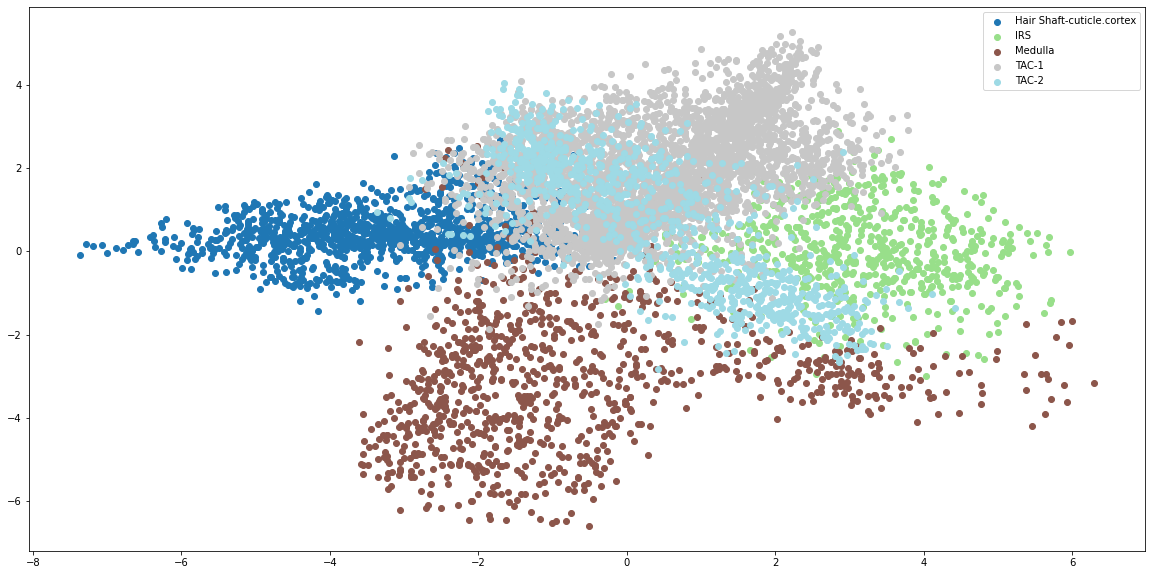

In [6]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
cluster_types = np.unique(shareseq_dataset.cell_labels)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(shareseq_dataset.cell_labels == cluster_type)[0]
    ax.scatter(ae_coordinates1[index,0], ae_coordinates1[index,1], color = colormap(i), label = cluster_type, alpha = 1)
        
ax.legend()

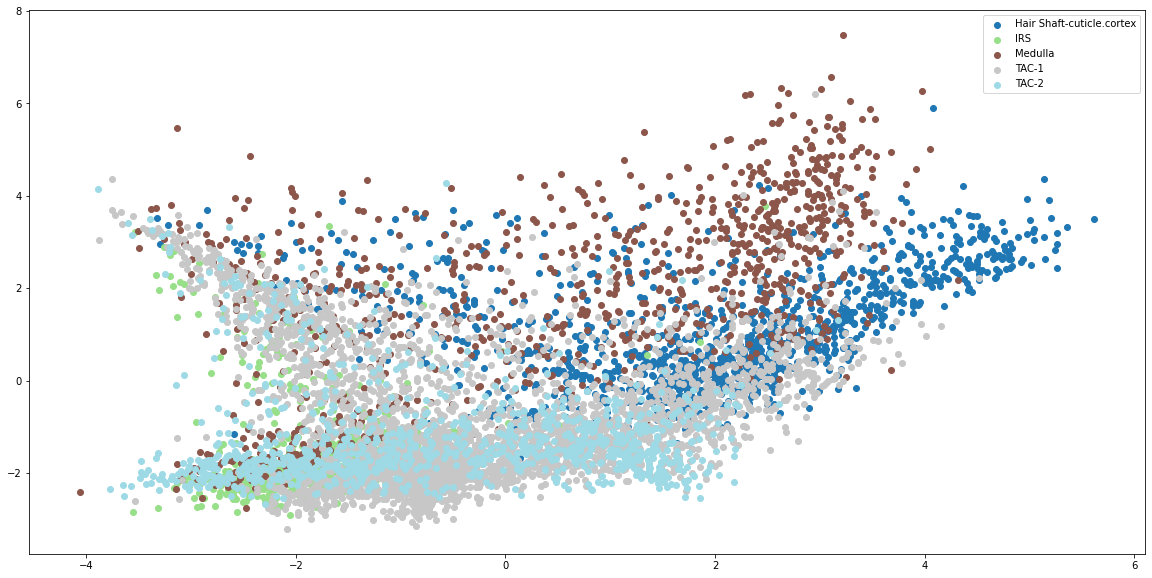

In [7]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
cluster_types = np.unique(shareseq_dataset.cell_labels)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(shareseq_dataset.cell_labels == cluster_type)[0]
    ax.scatter(ae_coordinates2[index,0], ae_coordinates2[index,1], color = colormap(i), label = cluster_type, alpha = 1)
        
ax.legend()

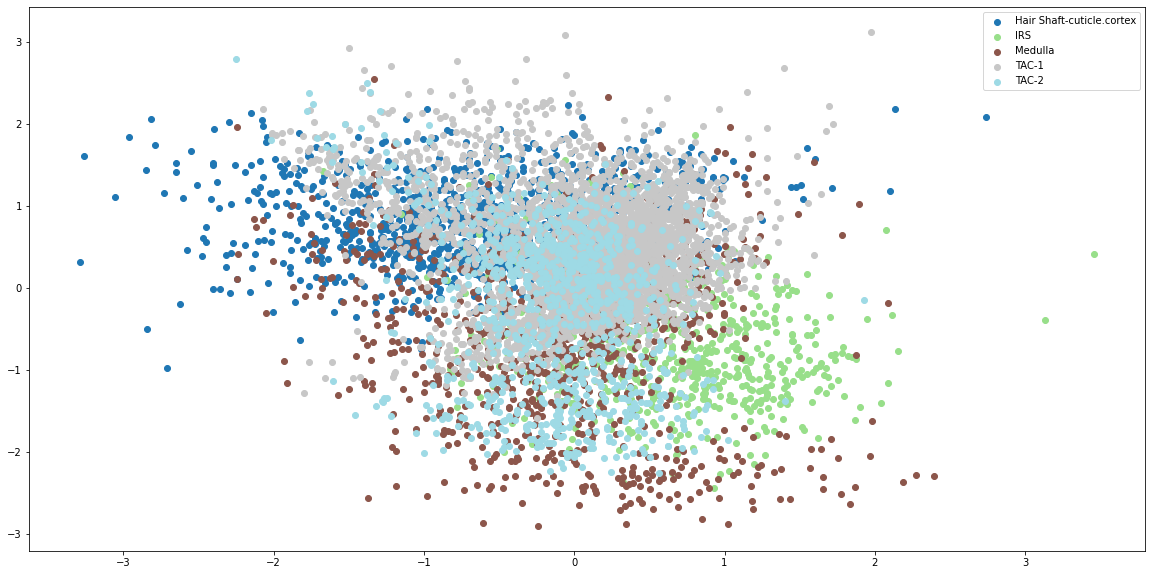

In [8]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
cluster_types = np.unique(shareseq_dataset.cell_labels)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(shareseq_dataset.cell_labels == cluster_type)[0]
    ax.scatter((ae_coordinates1[index,0] + ae_coordinates2[index,0])/2, (ae_coordinates1[index,1] + ae_coordinates2[index,1])/2, color = colormap(i), label = cluster_type, alpha = 1)
        
ax.legend()

# fig.savefig(save)